In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import MultiLabelBinarizer

import glob
import os

In [2]:
path_central_novice = r'C:\Users\imnku\Documents\Data Analysis\AMQ\CentralR-E'
all_files_central_novice = glob.glob(os.path.join(path_central_novice, "*.json"))

central_novice = pd.concat((pd.read_json(f) for f in all_files_central_novice), ignore_index=True)

path_east_novice = r'C:\Users\imnku\Documents\Data Analysis\AMQ\EastR-E'
all_files_east_novice = glob.glob(os.path.join(path_east_novice, "*.json"))

east_novice = pd.concat((pd.read_json(f) for f in all_files_east_novice), ignore_index=True)

novice = pd.concat(([central_novice, east_novice]), ignore_index=True)
novice = novice.replace('Unrated', 0)
novice = novice.astype({'difficulty': 'float'})
X = novice.drop(['annId', 'urls', 'siteIds', 'animeScore', 'altAnswers', 'selfAnswer', 'fromList', 'gameMode', 'correct'], axis=1).copy()

def find_n_correct(players):
    i = 0
    for player in players:
        if player['correct'] == True:
            i += 1
    return i

def find_gt(players):
    guess_times = [x['guessTime'] for x in players if 'guessTime' in x]
    return np.array(guess_times).mean()

def find_ng(players):
    no_guess = np.zeros(len(players))
    for i, x in enumerate(players):
        val = 0
        if x['active'] == True:
            if 'guessTime' in x:
                val = 0
            else:
                val = 1
        else:
            continue
        no_guess[i] = val
    return no_guess.sum()

def find_cgt(players):
    guess_times = np.array([x['guessTime'] for x in players if ('guessTime' in x and x['correct'] == True)])
    return np.array(guess_times).mean()

def find_igt(players):
    guess_times = np.array([x['guessTime'] for x in players if ('guessTime' in x and x['correct'] == False)])
    return np.array(guess_times).mean()

def find_scores(players):
    scores = np.zeros(len(players))
    for i, x in enumerate(players):
        scores[i] = x['score']
    return scores

X['avgGuessTime'] = X['players'].apply(find_gt)
X['n_correctGuess'] = X['players'].apply(find_n_correct)
X['n_noGuess'] = X['players'].apply(find_ng)
X['p_noGuess'] = X['n_noGuess']/X['activePlayers'] *100
X['p_correctGuess'] = X['n_correctGuess']/X['activePlayers']*100
X['avgGuessTime_c'] = X['players'].apply(find_cgt)
X['avgGuessTime_i'] = X['players'].apply(find_igt)
X['type_noNumber'] = X['type'].str.split().str[0]
X['samplePercent'] = X['startSample']/X['videoLength']
X['AiredDate'] = X['vintage'].replace({'Winter': '1', 'Spring': '4', 'Summer': '7', 'Fall': '10'}, regex=True)
X['AiredDate'] = pd.to_datetime(X['AiredDate'], format='%m %Y')

n_games = len(all_files_central_novice) + len(all_files_east_novice)
songs_played = X.shape[0]
guess_rate = X['p_correctGuess'].mean()
guess_time = X['avgGuessTime'].mean()
no_guess_rate = X['p_noGuess'].mean()
diff = X['difficulty'].mean()

op = X.loc[X['type_noNumber'] == 'Opening']
op_played = op.shape[0]
op_rate = op['p_correctGuess'].mean()
op_diff = op['difficulty'].mean()

ed = X.loc[X['type_noNumber'] == 'Ending']
ed_played = ed.shape[0]
ed_rate = ed['p_correctGuess'].mean()
ed_diff = ed['difficulty'].mean()

ins = X.loc[X['type_noNumber'] == 'Insert']
in_played = ins.shape[0]
in_rate = ins['p_correctGuess'].mean()
in_diff = ins['difficulty'].mean()

last_song = pd.DataFrame(X.loc[X['songNumber'] == 85]).reset_index(drop=True)
last_song['Scores'] = last_song['players'].apply(find_scores)

finalScores = np.concatenate(last_song['Scores'].values).astype(int)
end_mean = finalScores.mean()
end_std = finalScores.std()
end_max = finalScores.max()

mlb = MultiLabelBinarizer()
s = X['tags']
dummy = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=X.index)
X = pd.concat([X, dummy], axis=1)

mlb2 = MultiLabelBinarizer()
s = X['genre']
dummy = pd.DataFrame(mlb2.fit_transform(s), columns=mlb2.classes_, index=X.index)
X = pd.concat([X, dummy], axis=1)

X = X.drop(['tags', 'genre'], axis=1)

genres = X[mlb2.classes_].sum().sort_values(ascending=False)
g_perc = pd.Series(index=mlb2.classes_, dtype='float64')
for genre in mlb2.classes_:
    g_perc[genre] = X.loc[X[genre] == 1]['p_correctGuess'].mean()
genres = pd.concat([genres, g_perc], axis=1)
genres.columns = ['Count', 'Guess rate']
genres = genres.sort_values(by='Guess rate', ascending=False)

tags = X[mlb.classes_].sum().sort_values(ascending=False)
t_perc = pd.Series(index=mlb.classes_, dtype='float64')
for tag in mlb.classes_:
    t_perc[tag] = X.loc[X[tag] == 1]['p_correctGuess'].mean()
tags = pd.concat([tags, t_perc], axis=1)
tags.columns = ['Count', 'Guess rate']
tags = tags.sort_values(by='Count', ascending=False).head(30).sort_values(by='Guess rate', ascending=False)

C:\Users\imnku\AppData\Local\Temp\ipykernel_8528\4073742331.py:43: RuntimeWarning: Mean of empty slice.
  return np.array(guess_times).mean()
C:\Users\imnku\AppData\Local\Temp\ipykernel_8528\4073742331.py:47: RuntimeWarning: Mean of empty slice.
  return np.array(guess_times).mean()


In [3]:
general_table = [
    ['Games played', n_games],
    ['Songs played', songs_played],
    ['Correct guess rate (%)', '{:.2f}'.format(guess_rate)],
    ['Average difficulty', '{:.2f}'.format(diff)],
    ['Average guess time (s)', '{:.2f}'.format(guess_time/1000)],
    ['No guess rate (%)', '{:.2f}'.format(no_guess_rate)]
]
print(tabulate(general_table, tablefmt='fancy_grid'))

types_table = {
    'Openings': [op_played, op_rate, op_diff],
    'Endings': [ed_played, ed_rate, ed_diff],
    'Inserts': [in_played, in_rate, in_diff]
}
print(tabulate(types_table, tablefmt='fancy_grid', headers='keys', showindex=[
    'Songs played', 'Correct guess rate (%)', 'Average difficulty']
              ))

ends_table = {
    'Final score': ['{:.2f}'.format(end_mean), '{:.2f}'.format(end_std), end_max]
}
print(tabulate(ends_table, tablefmt='fancy_grid', headers='keys', showindex=[
    'Mean', 'STD', 'Highest']
              ))

╒════════════════════════╤═════════╕
│ Games played           │   25    │
├────────────────────────┼─────────┤
│ Songs played           │ 2125    │
├────────────────────────┼─────────┤
│ Correct guess rate (%) │   24.81 │
├────────────────────────┼─────────┤
│ Average difficulty     │   20.58 │
├────────────────────────┼─────────┤
│ Average guess time (s) │   10.88 │
├────────────────────────┼─────────┤
│ No guess rate (%)      │   38.56 │
╘════════════════════════╧═════════╛
╒════════════════════════╤════════════╤═══════════╤═══════════╕
│                        │   Openings │   Endings │   Inserts │
╞════════════════════════╪════════════╪═══════════╪═══════════╡
│ Songs played           │   568      │ 1065      │  492      │
├────────────────────────┼────────────┼───────────┼───────────┤
│ Correct guess rate (%) │    35.4877 │   21.0877 │   20.5445 │
├────────────────────────┼────────────┼───────────┼───────────┤
│ Average difficulty     │    27.1361 │   17.7153 │   19.2254 │
╘══════

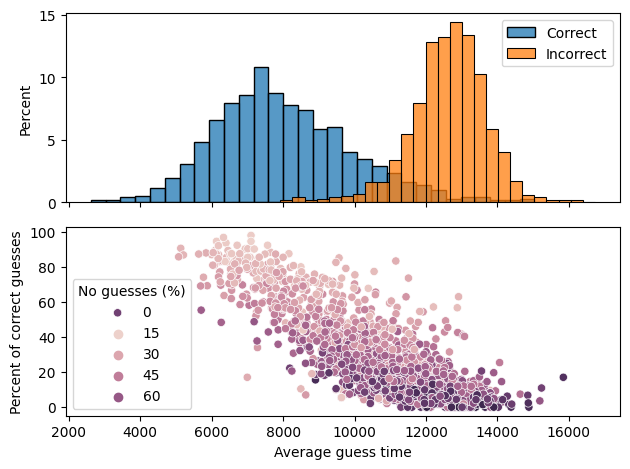

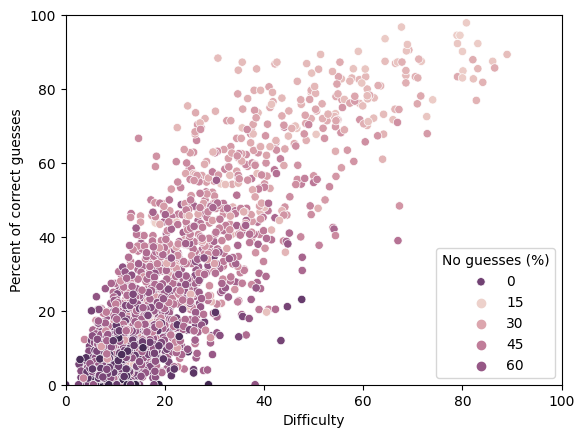

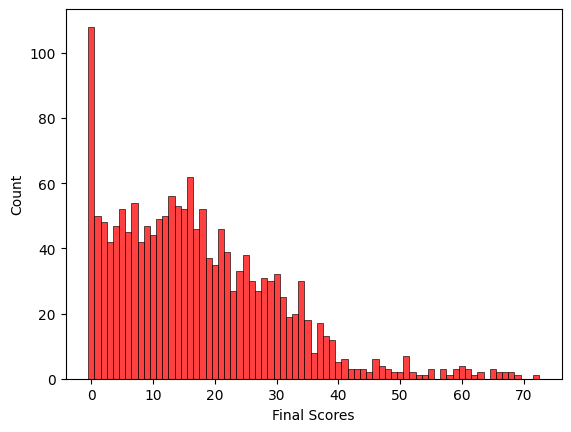

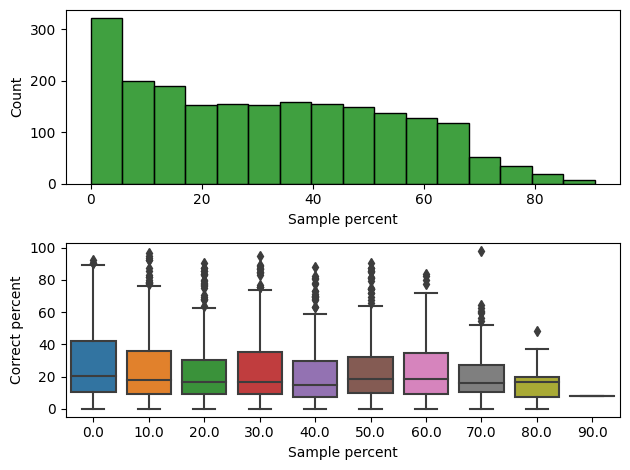

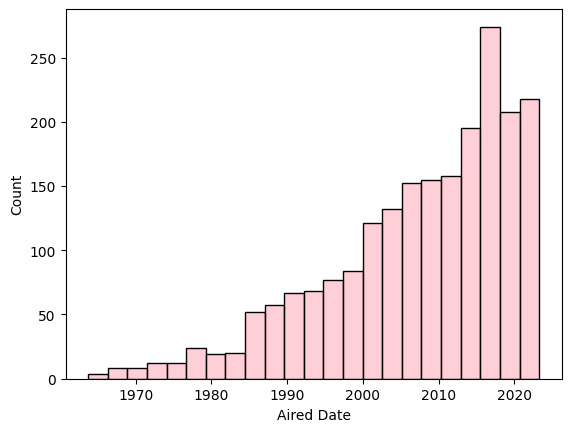

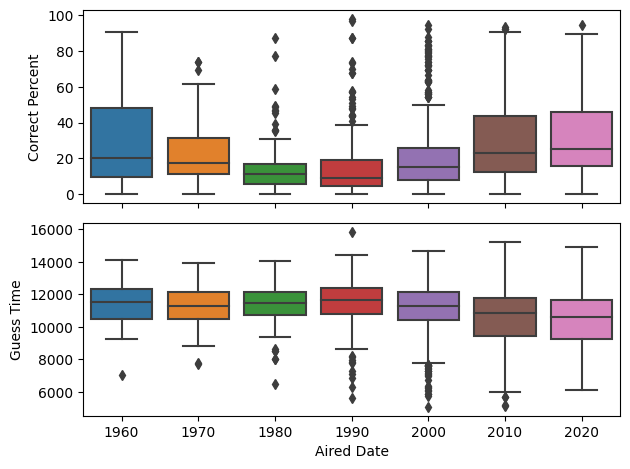

In [4]:
f, ax = plt.subplots(2, 1, sharex=True)
sns.histplot(X['avgGuessTime_c'], ax=ax[0], bins=30, stat='percent', label='Correct')
sns.histplot(X['avgGuessTime_i'], ax=ax[0], bins=30, stat='percent', label='Incorrect')
sns.scatterplot(X, y='p_correctGuess', x='avgGuessTime', hue='p_noGuess', ax=ax[1])
ax[1].set_xlabel('Average guess time')
ax[1].set_ylabel('Percent of correct guesses')
ax[0].legend()
ax[1].legend(title='No guesses (%)', labels=['0', '15', '30', '45', '60'])
f.tight_layout()
plt.show()

f, ax = plt.subplots(1, 1)
sns.scatterplot(X, x='difficulty', y='p_correctGuess', ax=ax, hue='p_noGuess')
ax.legend(title='No guesses (%)', labels=['0', '15', '30', '45', '60'])
ax.set_xlabel('Difficulty')
ax.set_ylabel('Percent of correct guesses')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.show()

f, ax = plt.subplots(1, 1)
sns.histplot(finalScores, discrete=True, ax=ax, color='red')
ax.set_xlabel('Final Scores')
plt.show()

f, ax = plt.subplots(2, 1, sharex=False)
sns.histplot(X['samplePercent']*100, ax=ax[0], color='green')
ax[0].set_xlabel('Sample percent')
seconds = X['samplePercent']*10
sns.boxplot(X, x=seconds.apply(np.floor)*10, y='p_correctGuess', ax=ax[1])
ax[1].set_xlabel('Sample percent')
ax[1].set_ylabel('Correct percent')
f.tight_layout()
plt.show()

f, ax = plt.subplots(1, 1)
sns.histplot(X['AiredDate'], ax=ax, color='pink')
ax.set_xlabel('Aired Date')
plt.show()

f, ax = plt.subplots(2, 1, sharex=True)
decade = X['AiredDate'].dt.year//10*10 
sns.boxplot(X, x=decade, y='p_correctGuess', ax=ax[0])
sns.boxplot(X, x=decade, y='avgGuessTime', ax=ax[1])
ax[0].set_xlabel('')
ax[1].set_xlabel('Aired Date')
ax[0].set_ylabel('Correct Percent')
ax[1].set_ylabel('Guess Time')
f.tight_layout()
plt.show()

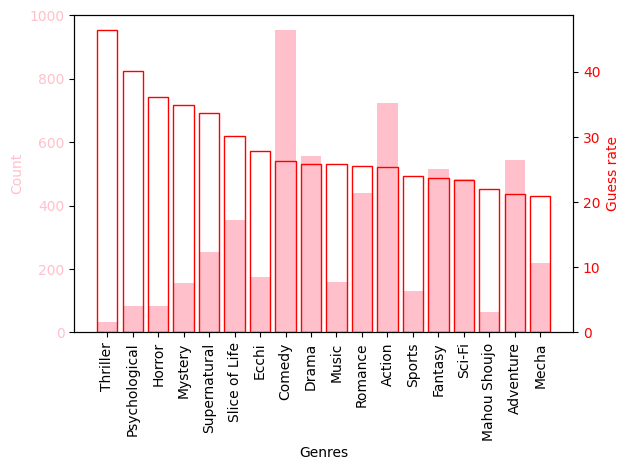

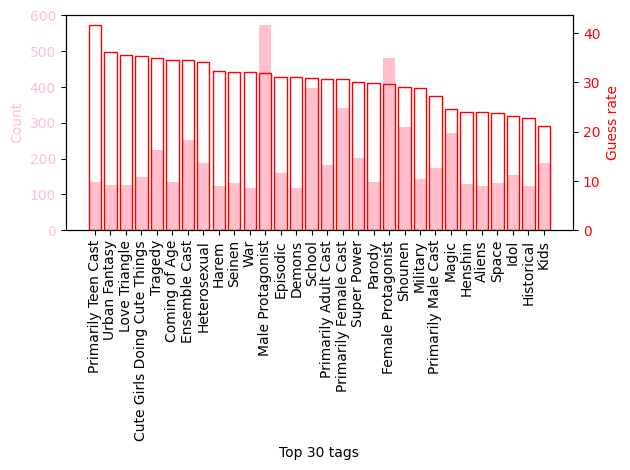

In [5]:
f, ax_p = plt.subplots()
color = 'pink'
ax_p.set_xlabel('Genres')
ax_p.set_ylabel('Count', color=color)
ax_p.bar(genres['Count'].keys().tolist(), genres['Count'], color=color)
ax_p.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax_c = ax_p.twinx()

color = 'red'
ax_c.set_ylabel('Guess rate', color=color)
ax_c.bar(genres['Count'].keys().tolist(), genres['Guess rate'], edgecolor=color, fill=False)
ax_c.tick_params(axis='y', labelcolor=color)

f.tight_layout()
plt.savefig(r'C:\Users\imnku\Downloads\genres.png')
plt.show()


f, ax_p = plt.subplots()
color = 'pink'
ax_p.set_xlabel('Top 30 tags')
ax_p.set_ylabel('Count', color=color)
ax_p.bar(tags['Count'].keys().tolist(), tags['Count'], color=color)
ax_p.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax_c = ax_p.twinx()

color = 'red'
ax_c.set_ylabel('Guess rate', color=color)
ax_c.bar(tags['Count'].keys().tolist(), tags['Guess rate'], edgecolor=color, fill=False)
ax_c.tick_params(axis='y', labelcolor=color)

f.tight_layout()
plt.savefig(r'C:\Users\imnku\Downloads\tags.png')
plt.show()

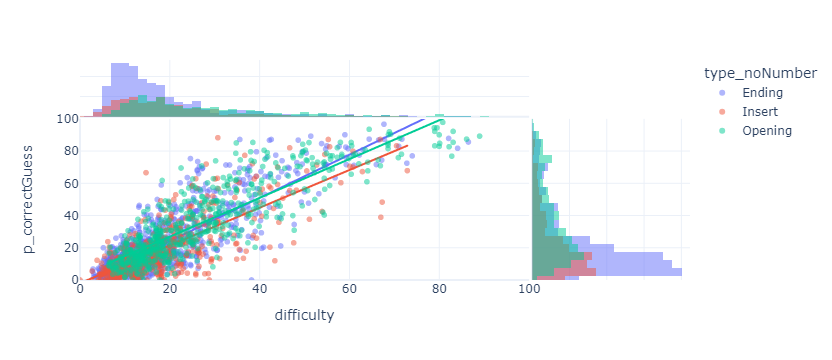

In [9]:
import plotly.express as px
px.scatter(
        X,
        x='difficulty',
        y='p_correctGuess',
        color='type_noNumber',
        marginal_x='histogram', 
        marginal_y='histogram',
        trendline='ols',
        template='plotly_white',
        range_x=[0, 100],
        range_y=[0, 100],
        opacity=0.5
        )